# Case-Explainer Tutorial: Iris Dataset

Welcome to this tutorial on **case-based explainability** using the classic Iris dataset!

## What You'll Learn

- How to create case-based explanations for ML predictions
- Understanding the correspondence metric
- Interpreting explanations through similar training examples
- Analyzing correspondence scores (neighbor agreement)

## What is Case-Based Explainability?

Instead of saying *"Feature X has importance 0.45"*, case-based explainability answers:

> **"This prediction was made because it resembles these 5 training examples"**

This approach is particularly valuable when:
- Domain experts need to verify predictions against known cases
- You want concrete examples rather than abstract feature importances
- The training data has meaningful context worth surfacing

## 1. Setup and Data Loading

First, let's import the required libraries and load the Iris dataset.

In [1]:
# Import libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Add case_explainer to path
sys.path.insert(0, '..')
from case_explainer import CaseExplainer

# Set random seed
np.random.seed(42)
print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load Iris dataset
data = load_iris()
X = data.data
y = data.target
feature_names = list(data.feature_names)
class_names = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Dataset: {len(X)} total samples")
print(f"Training: {len(X_train)} samples")
print(f"Testing: {len(X_test)} samples")
print(f"\nFeatures: {feature_names}")
print(f"Classes: {list(class_names.values())}")

Dataset: 150 total samples
Training: 105 samples
Testing: 45 samples

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa', 'versicolor', 'virginica']


## 2. Train a Classifier

We'll train a Random Forest classifier. Case-explainer works with any classifier!

In [3]:
# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.1%}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=list(class_names.values())))

Model Accuracy: 88.9%

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.78      0.93      0.85        15
   virginica       0.92      0.73      0.81        15

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45



## 3. Create the CaseExplainer

Now we initialize the explainer with our training data. It builds a k-NN index for fast lookups.

In [4]:
# Create explainer
explainer = CaseExplainer(
    X_train=X_train,
    y_train=y_train,
    feature_names=feature_names,
    class_names=class_names,
    algorithm='kd_tree',  # Fast for low-dimensional data
    scale_data=True       # Standardize features
)

print("\nExplainer initialized!")
print(f"Index built on {len(X_train)} training samples")

Building k-NN index (k=5, metric=euclidean, algorithm=kd_tree)...
Index built on 105 training samples

Explainer initialized!
Index built on 105 training samples


## 4. Explain a Single Prediction

Let's explain a test sample and see which training examples it resembles.

In [5]:
# Pick a test sample
test_idx = 0
test_sample = X_test[test_idx]
true_label = y_test[test_idx]

# Get explanation
explanation = explainer.explain_instance(
    test_sample=test_sample,
    k=5,  # Find 5 nearest neighbors
    model=clf,
    true_class=true_label
)

# Print summary
print(explanation.summary())

CASE-BASED EXPLANATION
Predicted class: virginica
True class: virginica ✓
Correspondence: 100.00% (high)

Nearest 5 neighbors:
------------------------------------------------------------
1. [✓] Index 88: class virginica, distance 0.3021
2. [✓] Index 82: class virginica, distance 0.4560
3. [✓] Index 9: class virginica, distance 0.5510
4. [✓] Index 22: class virginica, distance 0.5909
5. [✓] Index 23: class virginica, distance 0.6187


### Understanding the Correspondence Score

The **correspondence** quantifies agreement between the prediction and nearest neighbors:

- **High (≥85%)**: Strong agreement, high confidence
- **Medium (70-85%)**: Moderate agreement
- **Low (<70%)**: Weak agreement, uncertain prediction

Let's examine the neighbors in detail:

In [6]:
print(f"Prediction: {class_names[explanation.predicted_class]}")
print(f"True class: {class_names[explanation.true_class]}")
print(f"Correspondence: {explanation.correspondence:.1%} ({explanation.correspondence_interpretation})")
print(f"Correct: {explanation.is_correct()}")

print("\nNearest Neighbors:")
for i, neighbor in enumerate(explanation.neighbors, 1):
    print(f"\n{i}. Training sample #{neighbor.index}")
    print(f"   Distance: {neighbor.distance:.3f}")
    print(f"   Label: {class_names[neighbor.label]}")
    print(f"   Features: {neighbor.features}")

Prediction: virginica
True class: virginica
Correspondence: 100.0% (high)
Correct: True

Nearest Neighbors:

1. Training sample #88
   Distance: 0.302
   Label: virginica
   Features: [7.4 2.8 6.1 1.9]

2. Training sample #82
   Distance: 0.456
   Label: virginica
   Features: [7.2 3.  5.8 1.6]

3. Training sample #9
   Distance: 0.551
   Label: virginica
   Features: [7.1 3.  5.9 2.1]

4. Training sample #22
   Distance: 0.591
   Label: virginica
   Features: [7.6 3.  6.6 2.1]

5. Training sample #23
   Distance: 0.619
   Label: virginica
   Features: [7.7 2.8 6.7 2. ]


## 5. Visualize the Explanation

The plot shows neighbor distances colored by their class labels.

Radar plot not yet implemented, using bar plot instead.


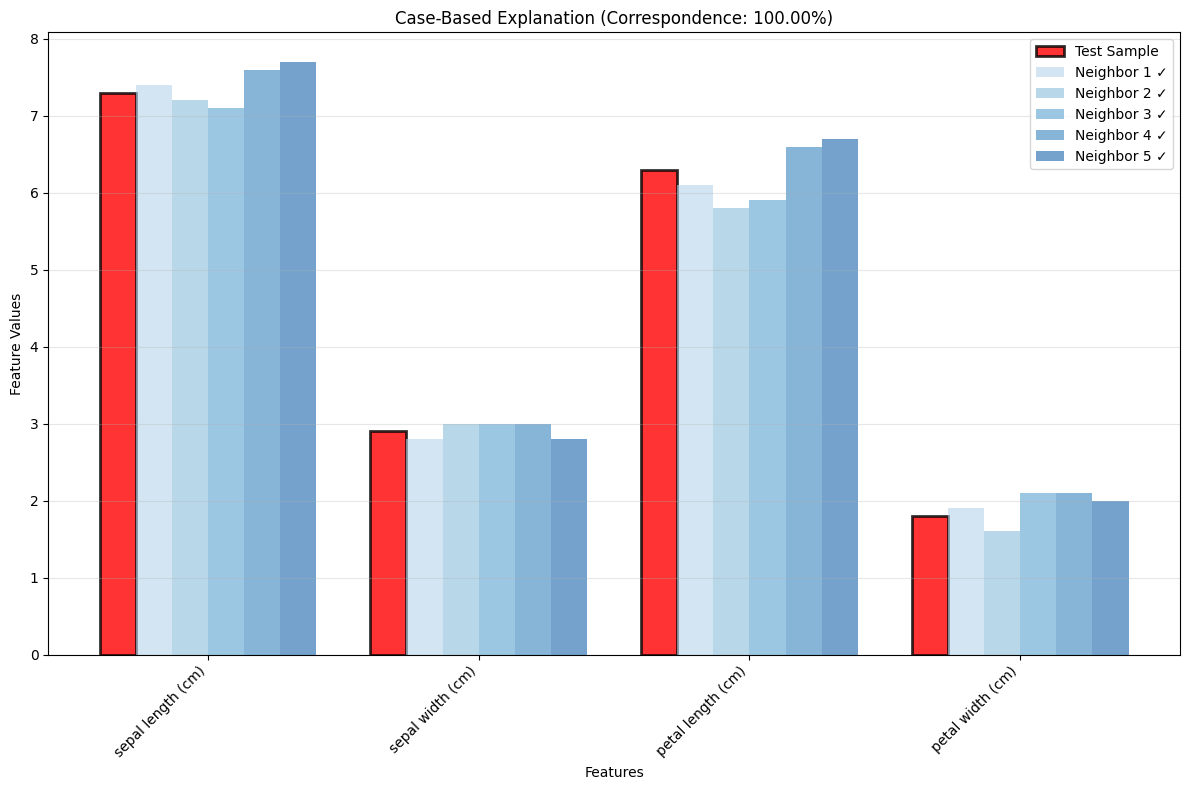

<Figure size 640x480 with 0 Axes>

In [7]:
# Create visualization
explanation.plot()
plt.tight_layout()
plt.show()

## 6. Batch Explanations

Let's explain all test samples and analyze the results.

In [8]:
# Explain all test samples
explanations = explainer.explain_batch(
    X_test=X_test,
    k=5,
    y_test=y_test,
    model=clf
)

print(f"Generated {len(explanations)} explanations")

Generated 45 explanations


### Analyze Correspondence Distribution

In [9]:
# Extract correspondence scores
correspondences = [exp.correspondence for exp in explanations]
correct_corr = [exp.correspondence for exp in explanations if exp.is_correct()]
incorrect_corr = [exp.correspondence for exp in explanations if not exp.is_correct()]

print("Correspondence Statistics:")
print(f"  Overall mean: {np.mean(correspondences):.1%}")
print(f"  Overall std: {np.std(correspondences):.1%}")
print(f"\n  Correct predictions: {np.mean(correct_corr):.1%}")
if incorrect_corr:
    print(f"  Incorrect predictions: {np.mean(incorrect_corr):.1%}")
else:
    print(f"  Incorrect predictions: None (perfect accuracy!)")

# Count by interpretation
high = sum(1 for exp in explanations if exp.correspondence_interpretation == 'high')
medium = sum(1 for exp in explanations if exp.correspondence_interpretation == 'medium')
low = sum(1 for exp in explanations if exp.correspondence_interpretation == 'low')

print(f"\nCorrespondence Levels:")
print(f"  High (≥85%): {high} samples")
print(f"  Medium (70-85%): {medium} samples")
print(f"  Low (<70%): {low} samples")

Correspondence Statistics:
  Overall mean: 92.7%
  Overall std: 15.8%

  Correct predictions: 96.8%
  Incorrect predictions: 59.7%

Correspondence Levels:
  High (≥85%): 36 samples
  Medium (70-85%): 2 samples
  Low (<70%): 7 samples


### Plot Correspondence Distribution

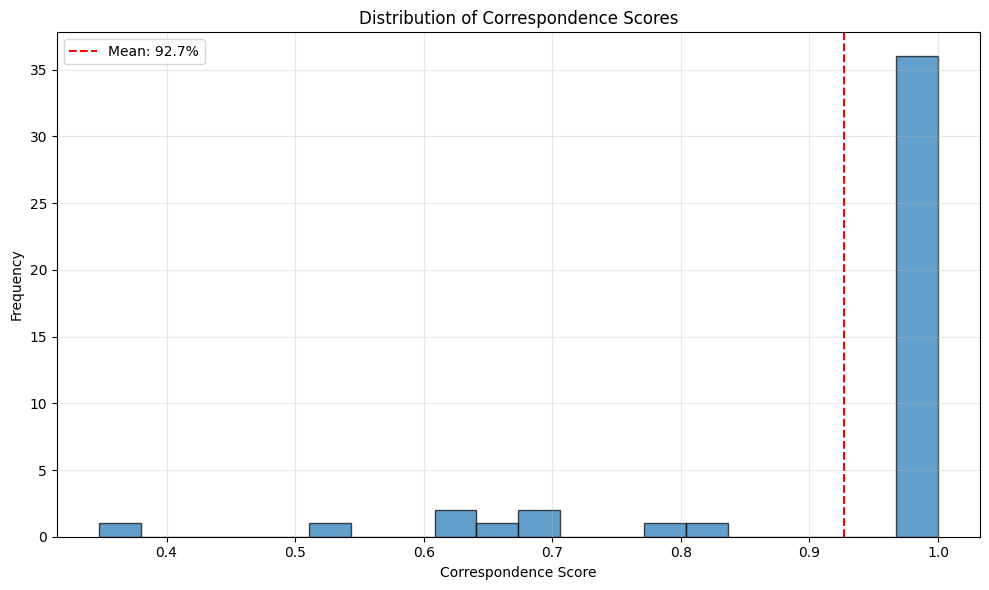

In [10]:
# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(correspondences, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(correspondences), color='red', linestyle='--', 
            label=f'Mean: {np.mean(correspondences):.1%}')
plt.xlabel('Correspondence Score')
plt.ylabel('Frequency')
plt.title('Distribution of Correspondence Scores')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Compare Correct vs Incorrect Predictions

/tmp/ipykernel_880628/292153287.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_corr, incorrect_corr], labels=['Correct', 'Incorrect'])


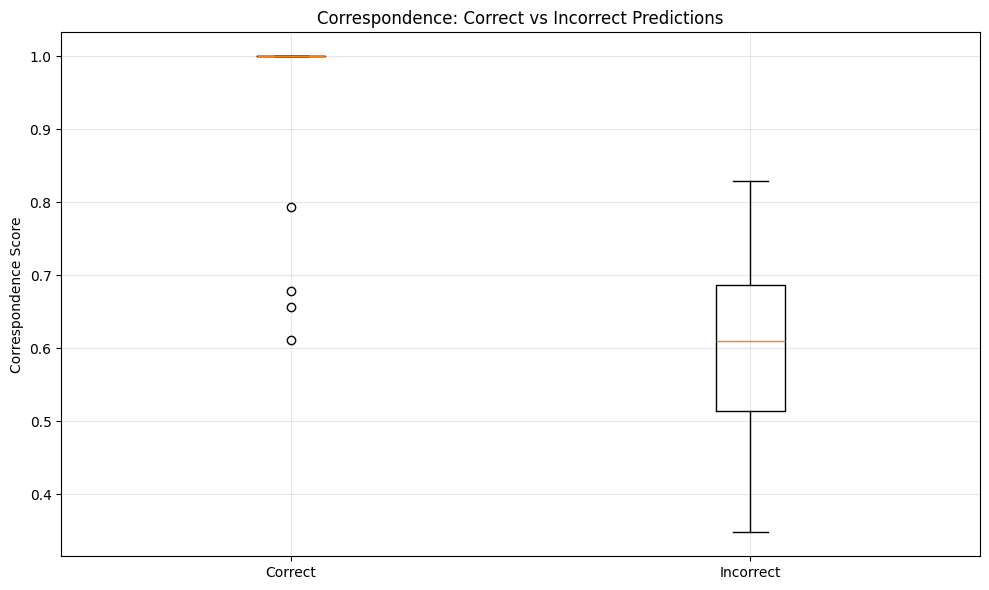


Insight: Correct predictions have 96.8% correspondence
         Incorrect predictions have 59.7% correspondence
         Difference: 37.1%


In [11]:
# Compare correspondence for correct vs incorrect
if incorrect_corr:
    plt.figure(figsize=(10, 6))
    plt.boxplot([correct_corr, incorrect_corr], labels=['Correct', 'Incorrect'])
    plt.ylabel('Correspondence Score')
    plt.title('Correspondence: Correct vs Incorrect Predictions')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nInsight: Correct predictions have {np.mean(correct_corr):.1%} correspondence")
    print(f"         Incorrect predictions have {np.mean(incorrect_corr):.1%} correspondence")
    print(f"         Difference: {np.mean(correct_corr) - np.mean(incorrect_corr):.1%}")
else:
    print("All predictions were correct! No incorrect predictions to compare.")

## 8. Inspect Low Correspondence Predictions

Predictions with low correspondence might be uncertain or unusual cases.

In [12]:
# Find predictions with lowest correspondence
sorted_exps = sorted(explanations, key=lambda x: x.correspondence)
lowest_5 = sorted_exps[:5]

print("5 Predictions with Lowest Correspondence:\n")
for i, exp in enumerate(lowest_5, 1):
    print(f"{i}. Correspondence: {exp.correspondence:.1%} ({exp.correspondence_interpretation})")
    print(f"   Predicted: {class_names[exp.predicted_class]}")
    print(f"   True: {class_names[exp.true_class]}")
    print(f"   Correct: {exp.is_correct()}")
    print()

5 Predictions with Lowest Correspondence:

1. Correspondence: 34.7% (low)
   Predicted: virginica
   True: versicolor
   Correct: False

2. Correspondence: 51.3% (low)
   Predicted: versicolor
   True: virginica
   Correct: False

3. Correspondence: 61.0% (low)
   Predicted: versicolor
   True: virginica
   Correct: False

4. Correspondence: 61.1% (low)
   Predicted: versicolor
   True: versicolor
   Correct: True

5. Correspondence: 65.6% (low)
   Predicted: virginica
   True: virginica
   Correct: True



## Key Takeaways

1. **Case-based explanations** provide concrete training examples as evidence
2. **Correspondence** quantifies how well neighbors agree with the prediction
3. **High correspondence** indicates confident predictions backed by similar training data
4. **Low correspondence** suggests unusual cases or uncertain predictions
5. **Correct predictions** generally have higher correspondence than incorrect ones

## Next Steps

Try the other tutorials:
- `02_breast_cancer_tutorial.ipynb` - Medical diagnosis domain
- `03_fraud_detection_tutorial.ipynb` - Financial domain with imbalanced data
- `04_hardware_trojan_tutorial.ipynb` - Security domain with large-scale data